# [CSCI 3397/PSYC 3317] Lab 4: Image Segmentation

**Posted:** Friday, February 21, 2024

**Due:** Wednesday, February 28, 2024

__Total Points__: 8 pts

__Submission__: please rename the .ipynb file as __\<your_username\>_lab4a.ipynb__ before you submit it to canvas. Example: weidf_lab4.ipynb.

In [ ]:
# download data
! wget https://bc-cv.github.io/csci3397/public/dip_registration/exemplar-001-cycle-01.ome.tiff -O exemplar-001-cycle-01.ome.tiff
! wget https://bc-cv.github.io/csci3397/public/dip_morph/binary_hole.png -O binary_hole.png
! wget https://bc-cv.github.io/csci3397/public/dip_morph/binary_noise.png -O binary_noise.png
! wget https://bc-cv.github.io/csci3397/public/dip_morph/binary_fm.png -O binary_fm.png
! wget https://bc-cv.github.io/csci3397/public/dip_morph/binary_fs.png -O binary_fs.png
! wget https://bc-cv.github.io/csci3397/public/dip_morph/cell.png -O cell.png
! wget https://bc-cv.github.io/csci3397/public/dip_morph/messi.png -O messi.png

# auxilary function
import matplotlib.pyplot as plt
from imageio import volread, imread
import numpy as np


def plotImgPair(img1, img2, cm = 'gray', title=['','']):
    fig, ax = plt.subplots(1, 2, figsize=(15, 20))
    for i,a in enumerate(ax):
        a.set_axis_off()
        if title[i] != '':
            a.set_title(title[i])
    ax[0].imshow(img1, cmap=cm)
    ax[1].imshow(img2, cmap=cm)

def imAdjust(I, thres=[1,99]):
    # compute percentile: remove too big or too small values
    I_low, I_high = np.percentile(I.reshape(-1), thres)
    # thresholding
    I[I > I_high] = I_high
    I[I < I_low] = I_low
    # scale to 0-1
    I = (I.astype(float)- I_low)/ (I_high-I_low)
    # convert it to uint8
    I = (I * 255).astype(np.uint8)
    return I

--2023-12-20 21:18:26--  https://bc-cv.github.io/csci3397/public/dip_registration/exemplar-001-cycle-01.ome.tiff
Resolving bc-cv.github.io (bc-cv.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to bc-cv.github.io (bc-cv.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66638807 (64M) [image/tiff]
Saving to: ‘exemplar-001-cycle-01.ome.tiff’

exemplar-001-cycle- 100%[===================>]  63.55M   124MB/s    in 0.5s    

2023-12-20 21:18:30 (124 MB/s) - ‘exemplar-001-cycle-01.ome.tiff’ saved [66638807/66638807]

--2023-12-20 21:18:30--  https://bc-cv.github.io/csci3397/public/dip_morph/binary_hole.png
Resolving bc-cv.github.io (bc-cv.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to bc-cv.github.io (bc-cv.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8193 (8.0K) [image/png]
Saving to: ‘binary_hole.png’

binary_hole.png

# <b>1. Semantic segmentation</b>

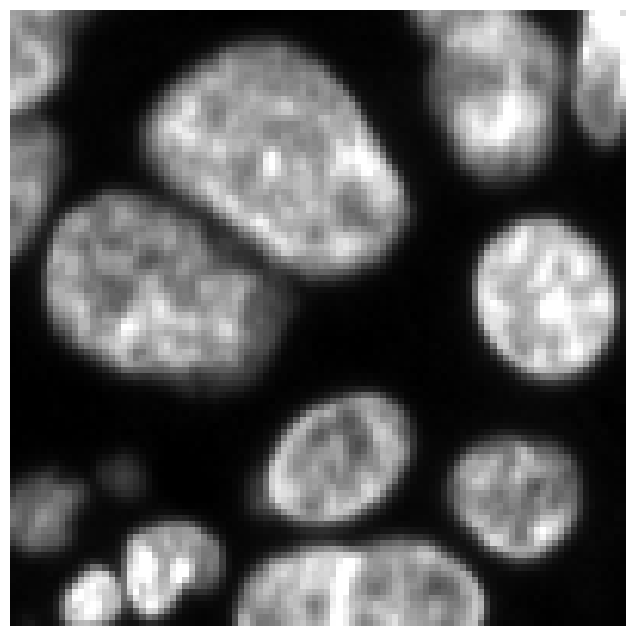

In [ ]:
img1 = imAdjust(volread('exemplar-001-cycle-01.ome.tiff')[0,687:787,687:787])

plt.figure(figsize=(8, 8))
plt.imshow(img1, cmap='gray')
plt.axis('off')
plt.show()


## 1.1 Naive thresholding (Lec. 14)

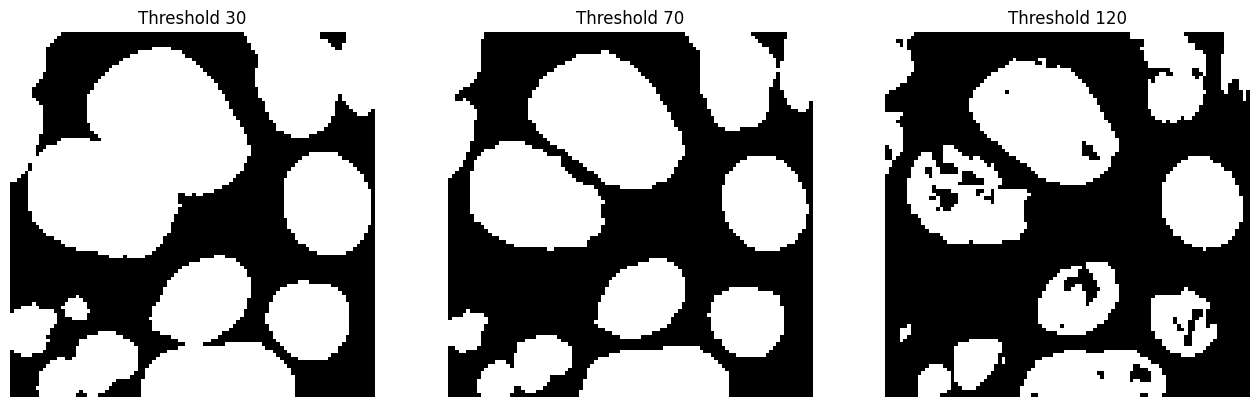

In [ ]:
ths = [30,70,120]

plt.figure(figsize=(16, 8))

for i,th in enumerate(ths):
    seg_semantic = (img1 > th)
    plt.subplot(1,3,i+1)
    plt.imshow(seg_semantic, cmap='gray')
    plt.title('Threshold %d' % th)
    plt.axis('off')


## 1.2 Otsu thresholding

In practice, we can apply a Gaussian filter to denoise the image a bit, so that the two classes can be better separated.

<img src="https://docs.opencv.org/4.x/otsu.jpg">

[More details](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html)


(-0.5, 99.5, 99.5, -0.5)

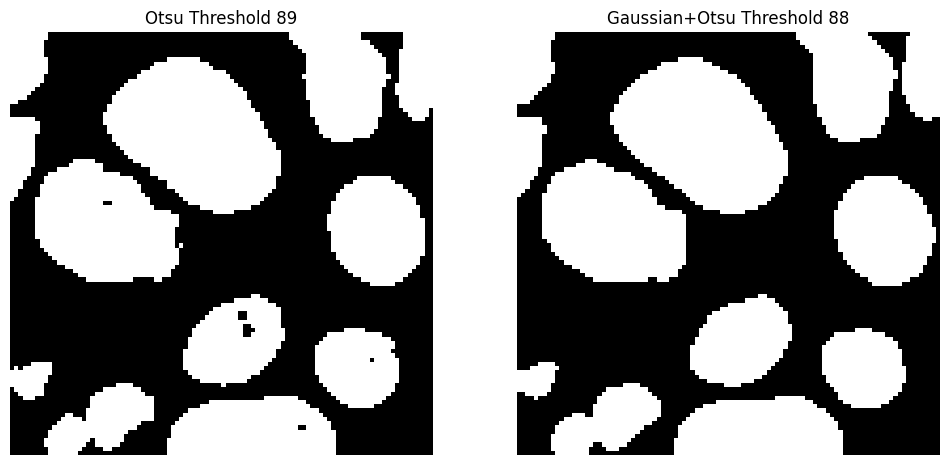

In [ ]:
import cv2

# direct Ostu
th_otsu, img1_otsu = cv2.threshold(img1, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Gaussian blur + Ostu
img1_blur = cv2.GaussianBlur(img1,(5,5),0)
th_blur_otsu, img1_blur_otsu = cv2.threshold(img1_blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)



plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img1_otsu, cmap='gray')
plt.title('Otsu Threshold %d' % th_otsu)
plt.axis('off')
plt.subplot(122)
plt.imshow(img1_blur_otsu, cmap='gray')
plt.title('Gaussian+Otsu Threshold %d' % th_blur_otsu)
plt.axis('off')

# <b>2. Instance segmentation</b>

## 2.1 Connected component (Lec. 14)

Notice that thare are some segments have false merge error.


(-0.5, 99.5, 99.5, -0.5)

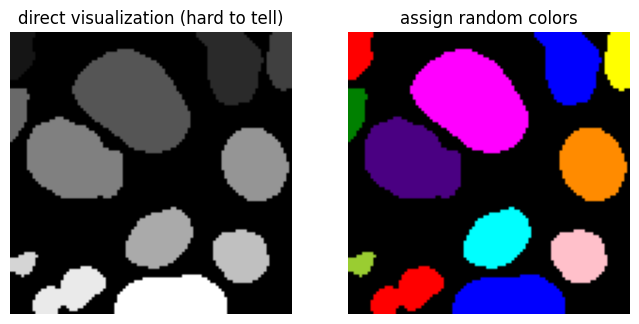

In [ ]:
from skimage.measure import label
from skimage.color import label2rgb


seg_inst = label(img1_blur_otsu)

plt.figure(figsize=(8, 8))
plt.subplot(121)
plt.imshow(seg_inst, cmap='gray')
plt.title('direct visualization (hard to tell)')
plt.axis('off')
plt.subplot(122)
plt.imshow(label2rgb(seg_inst, bg_label=0))
plt.title('assign random colors')
plt.axis('off')


## 2.2 Watershed (Lec. 15)


### Step 1. Distance transform



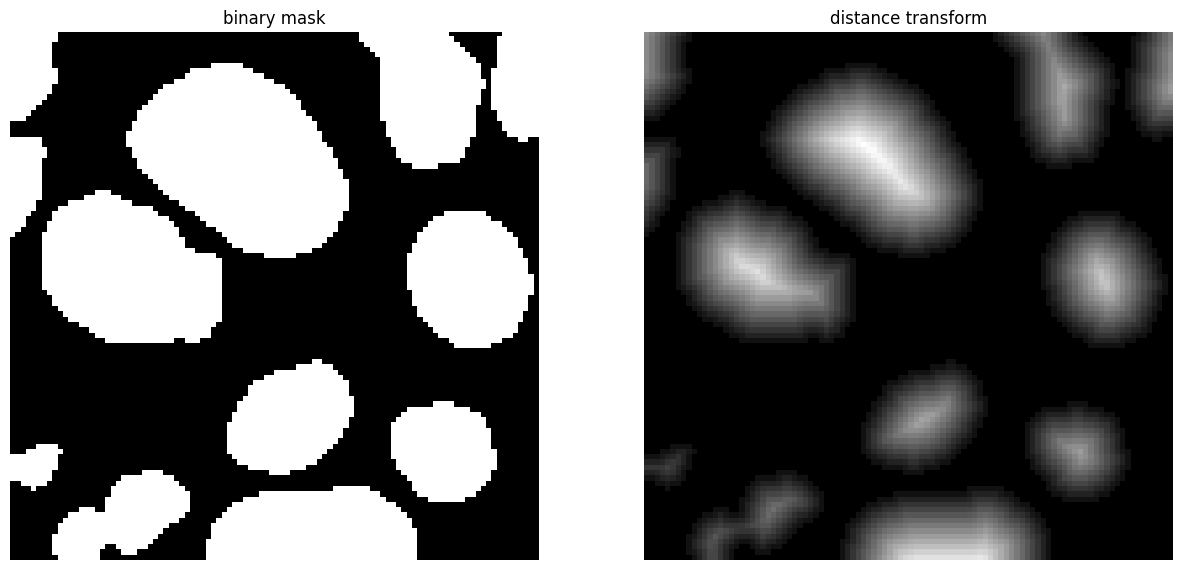

In [ ]:
from scipy import ndimage as ndi
distance = ndi.distance_transform_edt(img1_blur_otsu)
plotImgPair(img1_blur_otsu, distance, title=['binary mask', 'distance transform'])

### Step 2. Find local optima


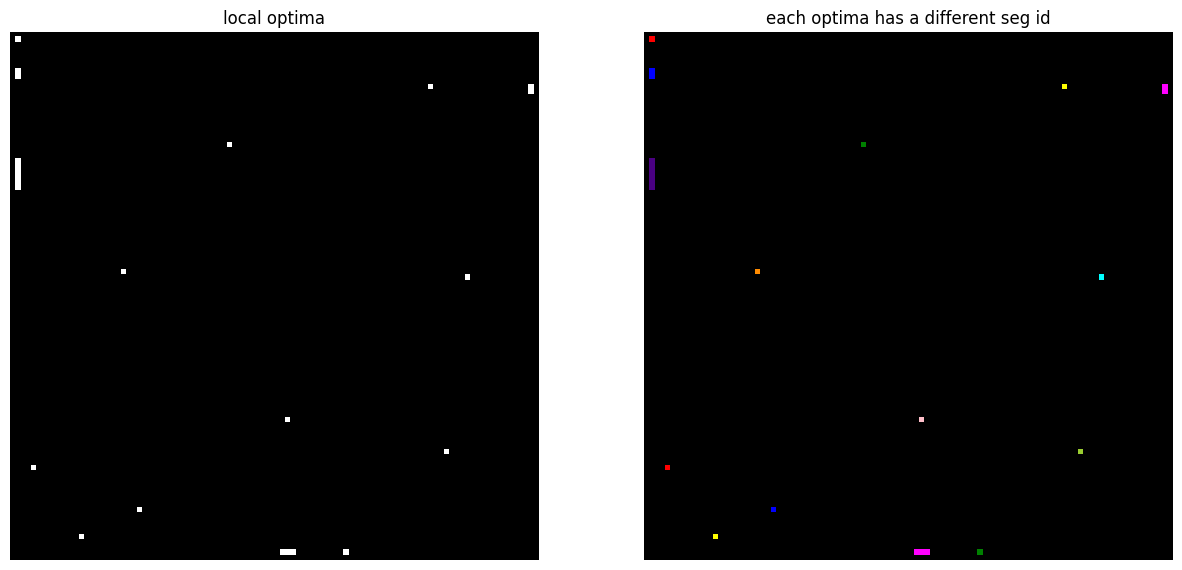

In [ ]:
from skimage.feature import peak_local_max

# partially determined by the size of a cell
optima_window_size = 15

coords = peak_local_max(distance,\
                        footprint=np.ones((optima_window_size, optima_window_size)),\
                        labels=img1_blur_otsu)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)

# the points are small
plotImgPair(mask, label2rgb(markers, bg_label=0), title=['local optima','each optima has a different seg id'])

### Step 3. Watershed transform

It fixes the false merge, but introduces some false splits...

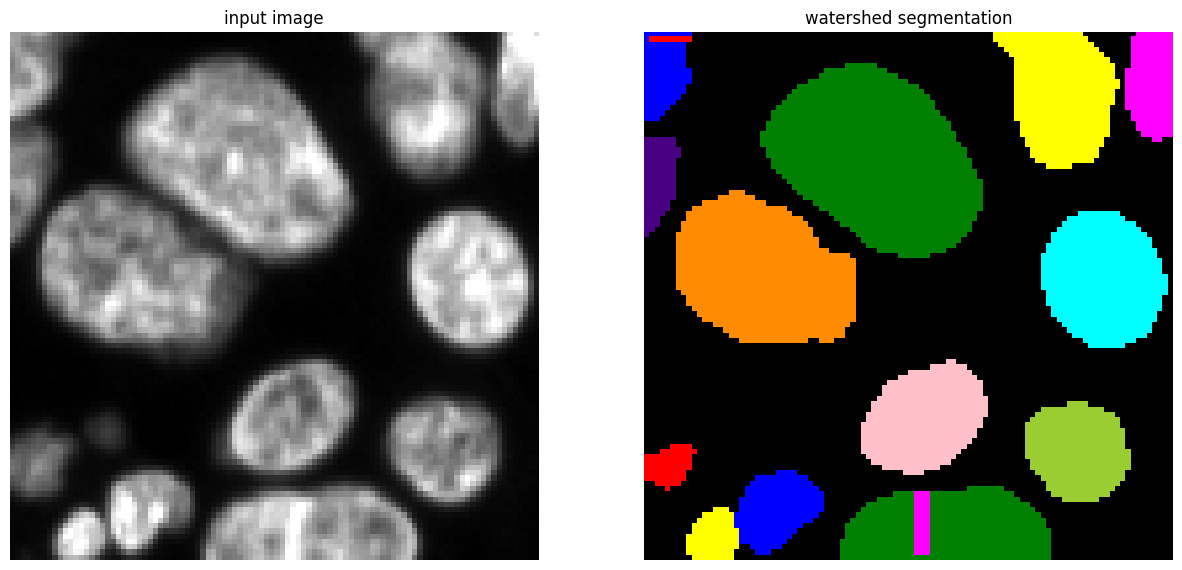

In [ ]:
from skimage.segmentation import watershed
seg_watershed = watershed(-distance, markers, mask=img1_blur_otsu)
plotImgPair(img1, label2rgb(seg_watershed, bg_label=0), title=['input image','watershed segmentation'])

## 2.3 Graph-based Segmentation (Lec. 15)

https://docs.opencv.org/3.4/d8/d83/tutorial_py_grabcut.html

### Rectangle mask

<ipython-input-9-475e89529aea>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread('messi.png')


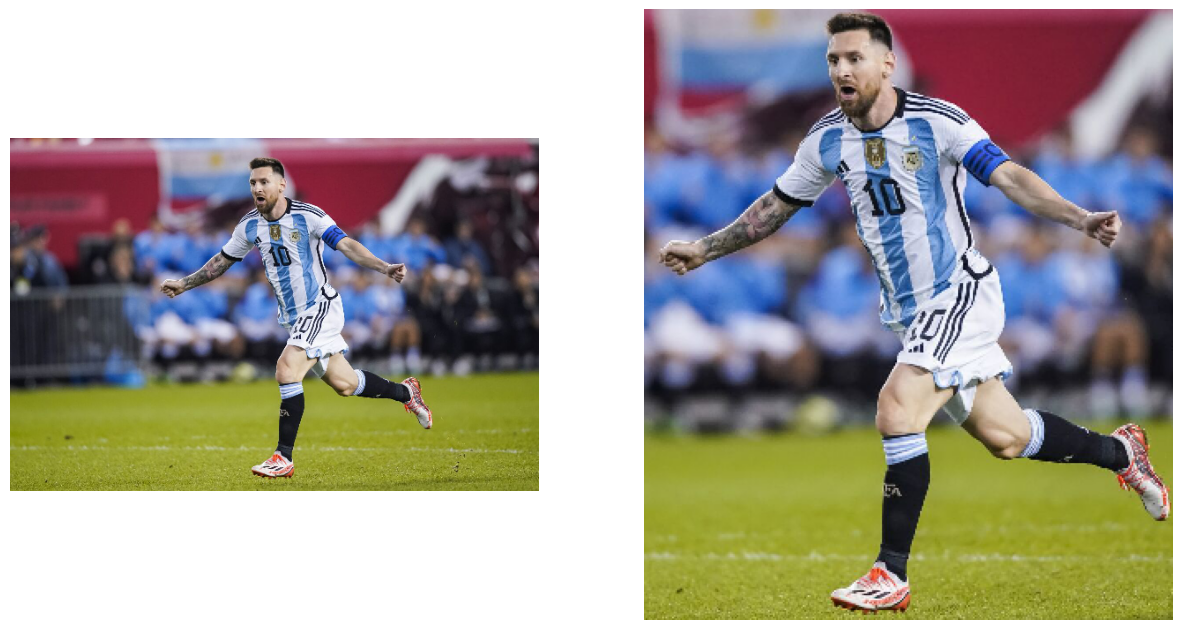

In [ ]:
img = imread('messi.png')
rect = (161,20,320,370)
plotImgPair(img, img[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]])

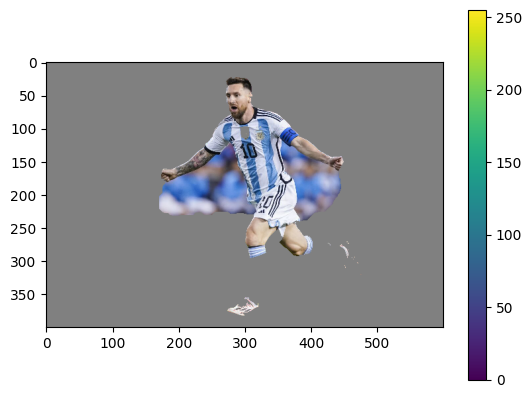

(<matplotlib.image.AxesImage at 0x79f3f5995090>,
 None)

In [ ]:
import cv2

# zero initialization
mask = np.zeros(img.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
num_iter = 5


cv2.grabCut(img, mask, rect, bgdModel,fgdModel,num_iter,cv2.GC_INIT_WITH_RECT)

img2 = img.copy()
# find background region
mask_bg = np.tile(((mask==2)+(mask==0)).astype('uint8')[:,:,None], [1,1,3])
img2[mask_bg>0] = 128
plt.imshow(img2),plt.colorbar(),plt.show()

### Add manual correction
The mask above is a good initialization. However, the legs are missing and the area under the arms are not part of the body.

We will use the following GUI to
- pick the green color and mark the skeleton of the human (teach GrabCut that these pixels are foreground)
- pick the red color and mark the area under the arm (teach GrabCut that these pixels are background)
- save the image

A sample mask image looks like this: <img width=200 src="https://bc-cv.github.io/csci3397/public/dip_morph/messi_mask.png"/>

Acknowledgement: GUI code is based on https://gist.github.com/rickkk856/6a2800cc84dd8fd456074e5a467edc47

In [ ]:
import ipywidgets as widgets
from ipywidgets import Layout, Button, Box
from IPython.display import display, HTML, Image
from google.colab.output import eval_js
from base64 import b64decode

Canvas_Size = img.shape[:2]
Brush_Size = 10 #@param {type:"slider", min:0, max:100, step:5}
Button_Size = 50
filename = "messi_mask"#@param [] {allow-input: true}
filename = filename + ".png"


def getJS(width, height, brush_size, button_size):
  js_code = '''
  <style>
    .colors-buttons div {
        width: 30px;
        height: 30px;
        margin: 2px;}
    div {
        display: flex;
        border:1px solid black;
    }

  #container{
      display:inline-block;
      width: '''+str(width)+'''px;
      height: '''+str(height)+'''px;
      margin: 0 -0px;
      background: white;
      position:relative;
      border:1px solid black; }

  .img{position:absolute;z-index:1;opacity:0.5}

  #gameCanvas{
      position:relative;
      z-index:20;
  }
  </style>
  <div id="container">
      <img src="https://bc-cv.github.io/csci3397/public/dip_morph/messi.png" class='img'>
      <canvas id="gameCanvas" width="'''+str(width)+'''" height="'''+str(height)+'''"></canvas>
  </div>

  <div class="colors-buttons">
    <div class="color" style="background-color: #00FF00;" id-color="#00FF00"></div>
    <div class="color" style="background-color: #FF0000;" id-color="#FF0000"></div>
  </div>

  <script>
    var canvas = document.querySelector('canvas')
    var ctx = canvas.getContext('2d')
    var Brush_Size = '''+str(brush_size)+'''

    var button = document.querySelector('button')
    var mouse = {x: 0, y: 0}


    canvas.addEventListener('mousemove', function(e) {
      mouse.x = e.pageX - this.offsetLeft - '''+str(button_size)+'''
      mouse.y = e.pageY - this.offsetTop
    })
    canvas.onmousedown = ()=>{
      ctx.beginPath()
      ctx.moveTo(mouse.x, mouse.y)

      canvas.addEventListener('mousemove', onPaint)
    }
    canvas.onmouseup = ()=>{
      canvas.removeEventListener('mousemove', onPaint)
    }
    var onPaint = ()=>{

      ctx.fillRect(mouse.x-( Brush_Size/2), mouse.y-(Brush_Size/2), Brush_Size, Brush_Size)

      ctx.stroke()
    }
    ctx.fillStyle = "00FF00";
    const colors = document.getElementsByClassName('color');
    Array.from(colors).forEach(color => {
      color.addEventListener('click', (event) => {
          const colorSelected = event.target.getAttribute('id-color');
          ctx.fillStyle = colorSelected;
      });
  });

      // FINISH BUTTON
    var data = new Promise(resolve=>{
      button.onclick = ()=>{
        resolve(canvas.toDataURL('image/jpg'))
      }
    })
  </script>
  '''
  return js_code


## Function to Appear Image Canvas
def draw(filename=filename,  w=100, h=100, Brush_Size=Brush_Size):
  display(HTML(getJS(w, h, Brush_Size, Button_Size)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  if AttributeError:
    pass
  with open(filename, 'wb') as f:
    f.write(binary)
  return len(binary)

## Action for Reset Button
def on_button_clicked(b):
  with output:
    data = eval_js("data")
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
      f.write(binary)
  return len(binary)
  if button2.on_click(on_button_clicked2):
    pass


## Show Save Button & Save outputs
button = widgets.Button(description="Save", layout=Layout(width='%dpx'%Button_Size, height='%dpx'%Button_Size))
button.on_click(on_button_clicked)
output = widgets.Output()
display(button, output)

## Show Canvas for the First Time
draw(filename=filename,  w=Canvas_Size[1], h=Canvas_Size[0], Brush_Size=Brush_Size)
print("Image Saved at")

Button(description='Save', layout=Layout(height='50px', width='50px'), style=ButtonStyle())

Output()

Visualize the labeled mask

In [ ]:
# you can optionally download the mask directly
# ! wget https://bc-cv.github.io/csci3397/public/dip_morph/messi_mask.png -O messi_mask.png
plotImgPair(imread('messi_mask.png')[:,:,0],imread('messi_mask.png')[:,:,1], title=['background','foreground'])

In [ ]:
import cv2

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

# mask initialization
mask_rect2 = mask.copy()
mask_manual = imread('messi_mask.png')
# background
mask_rect2[mask_manual[:,:,0]>200] = 0
# foreground
mask_rect2[mask_manual[:,:,1]>200] = 1


mask_manual_out, bgdModel, fgdModel = cv2.grabCut(img, mask_rect2, None, bgdModel,fgdModel, num_iter, cv2.GC_INIT_WITH_MASK)
mask_manual_out = np.tile(np.where((mask_manual_out==2)|(mask_manual_out==0),0,1).astype('uint8')[:,:,None], [1,1,3])
img2 = img.copy()
img2[mask_manual_out==0] = 128
plt.imshow(img2)
plt.show()

# <b> 3. Morphology Operations (Lec. 15)</b>

In [ ]:
from scipy.ndimage.morphology import binary_fill_holes
from scipy.ndimage.morphology import binary_erosion,binary_dilation
from scipy.ndimage.morphology import binary_closing,binary_opening

## 3.1 Basic operations


### Fill holes


In [ ]:
im_hole = imread('binary_hole.png')
im_hole_out = binary_fill_holes(im_hole)
plotImgPair(im_hole, im_hole_out, title=['input image', 'filled holes'])

### Erosion: remove noise

In [ ]:
im_noise = imread('binary_noise.png')
im_noise_out = binary_erosion(im_noise, np.ones([3,3]), 1)
plotImgPair(im_noise, im_noise_out, title=['input image', 'denoised image'])

### Dilation: fix false split

In [ ]:
im_fs = imread('binary_fs.png')
im_fs_out = binary_dilation(im_fs, np.ones([3,3]), 5)
plotImgPair(im_fs, im_fs_out, title=['input image', 'merged false split'])

## 3.2 Composite operations

### Closing: fix false splits + preserve shape


In [ ]:
im_fs = imread('binary_fs.png')
im_fs_close = binary_dilation(im_fs, np.ones([3,3]), 5)
im_fs_close2 = binary_closing(im_fs, np.ones([3,3]), 5)
plotImgPair(im_fs_close, im_fs_close2, title=['binary dilation', 'binary closing'])

### Opening: fix false merge + preserve shape


In [ ]:
im_fm = imread('binary_fm.png')
#imsave('lab4/binary_fm.png', im_fm[::8,::8,0])
im_fm_open = binary_dilation(binary_erosion(im_fm, np.ones([3,3]), 25), np.ones([3,3]), 25)
im_fm_open2 = binary_opening(im_fm, np.ones([3,3]), 25)
plotImgPair(im_fm, im_fm_open, title=['input image', 'split false merge'])

# [8 pts] Exercise
Let's apply what we learnt above to a new type of cell image.
- The cell borders are white now. The segments within the white borders are cells
- No need to get perfect results. Something reasonable is good


[[Segmentation of many different types of images/cells]](https://www.cellpose.org/)

In [ ]:
from imageio import imread,imsave

im = imread('cell.png')
plt.imshow(im, cmap='gray')
plt.axis('off')

## (1) [2 pts] semantic segmentation

Compute the binary image where the cell segments are 1 and background 0.

In [ ]:
### Your code starts here
im_seg_semantic = ???


### Your code ends here

plt.imshow(im_seg_semantic, cmap='gray')
plt.axis('off')
plt.show()

## (2) [2 pts] Instance segmentation

Based on the semantic segmentation above, use connected-component method to assign indivisual cells to different segment ids and visualize them in random colors. (okay to have errors).

In [ ]:
### Your code starts here
seg_inst = ???
seg_inst_color = ???
### Your code ends here


plt.imshow(seg_inst_color)
plt.axis('off')
plt.show()


## (3) [4 pts] Measurement and Table I/O

- [2 pts] Compute the circularity of all the segmented cells. (hint: need to get the statistics of the needed measurements)
- [1 pt] Save the result into a csv file `cell_stats.csv` with header: {"cell id", "circularity"}
- [1 pt] Load the result and plot the circularity histogram

If your instance segment is great, you can just say "there's no error".

In [ ]:

from skimage.measure import label, regionprops_table
from skimage.color import label2rgb
from math import pi


## find circularity
# first, keep only the nonzero segments (areas that were segmented)
ui,uc = np.unique(seg_inst[seg_inst>0], return_counts=True)

# then, remove small segments below size 100 (smaller segments are artifacts, probably not cells that we're interested in)
thres_size = 100
relabel = np.zeros(ui.max()+1, np.uint16)
relabel[ui[uc>thres_size]] = np.arange(1, (uc>thres_size).sum()+1)
seg_inst_clean = relabel[seg_inst]


### Your code starts here
# lookup area and perimeter from regionprops table, keeping segment label
table_from_clean = ???
# calculate circularity
table_from_clean['circularity'] = ???

## save result to csv
# create a Nx2 matrix: id, circularity
out = ???
np.savetxt('cell_stats.csv', out, header='cell id,circularity', delimiter=',', comments='')


## load result and plot circularity histogram
circularity_val = ???

plt.hist(circularity_val)
plt.title('Circularity distribution of cleaned segments')
plt.show()
### Your code ends here